# Ensemble models to Predict Crash Severity

#### This notebook contains our ensemble methods that predict the label, "crash severity". Crash Severity can be broken into 5 categories:
- K. Fatal Injury
- A. Severe Injury
- B. Visible Injury
- C. Nonvisible Injury
- O. Property Damage Only

In [1]:
import pandas as pd
import re
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Ensemble Models -- Distracted factors not included

### Pipeline -- Distracted factors not included

In [2]:
df = pd.read_csv("crash_data_nfactors.csv")

In [3]:
df.shape

(1128862, 20)

In [4]:
X = df.drop(columns=['Crash_Severity'])
y = df['Crash_Severity']

In [5]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

print(y_enc)

[4 4 1 ... 1 1 4]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.30,
    # stratify=y_enc,
    random_state=42
)

In [7]:
numeric_feats = ['Vehicle_Count','Speed_Posted_max']
numeric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_feats = [
    'Intersection_Type','Area_Type','Roadway_Alignment',
    'Light_Condition','Weather_Condition',
    'Roadway_Surface_Condition','Roadway_Surface_Type',
    'Traffic_Control_Type','Traffic_Control_Status',
    'Collision_Type','First_Harmful_Event',
    'day_of_week','time_of_day',
]
categorical_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_feats),
    ('cat', categorical_pipe, categorical_feats)
])


## Random Forest

In [8]:
# process
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [9]:
# fit model
rf = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2,
                              n_estimators=100, random_state=42)
rf.fit(X_train_prep, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [11]:
y_pred = rf.predict(X_test_prep)

In [12]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.6800
Classification Report:
              precision    recall  f1-score   support

           A       0.42      0.00      0.00     16404
           B       0.56      0.04      0.08     66161
           C       0.00      0.00      0.00     26285
           K       0.65      0.01      0.01      2267
           O       0.68      1.00      0.81    227542

    accuracy                           0.68    338659
   macro avg       0.46      0.21      0.18    338659
weighted avg       0.59      0.68      0.56    338659



/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
y_proba = rf.predict_proba(X_test_prep)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print(f"ROC-AUC (macro): {auc:.4f}")

ROC-AUC (macro): 0.7070


/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x600 with 0 Axes>

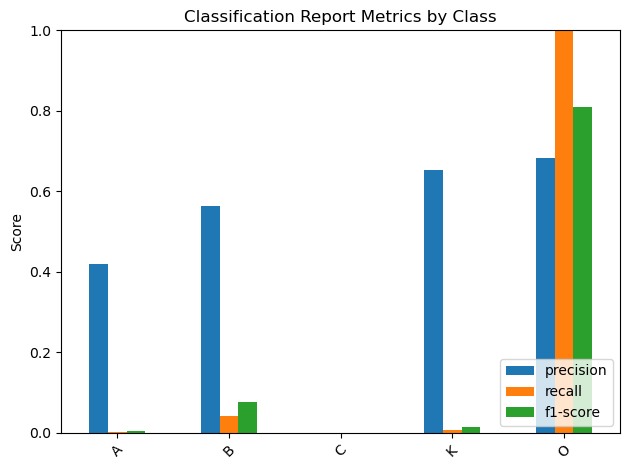

In [14]:
# plot report
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

class_metrics = report_df.iloc[:-3][['precision', 'recall', 'f1-score']]

plt.figure(figsize=(10, 6))
class_metrics.plot(kind='bar')
plt.title("Classification Report Metrics by Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

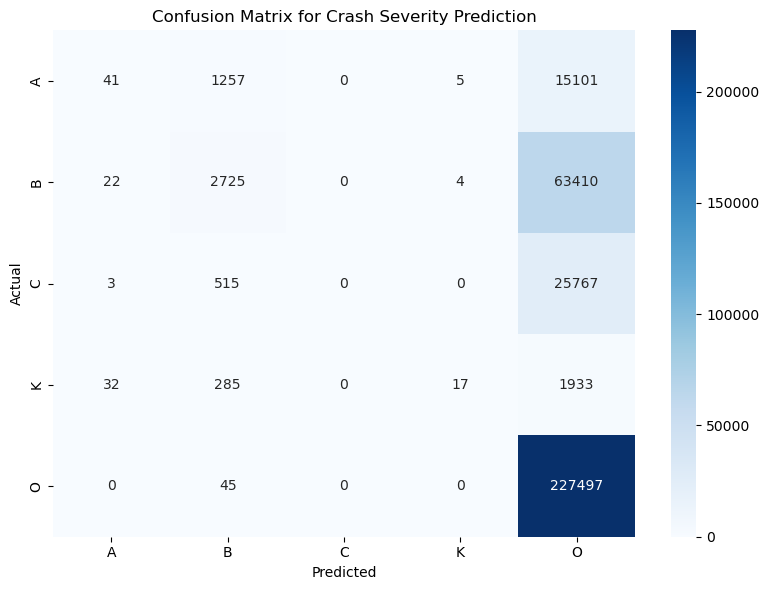

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Crash Severity Prediction')
plt.tight_layout()
plt.show()

                                               Feature  Importance
105                        First_Harmful_Event_19. Ped    0.153422
81                              Collision_Type_12. Ped    0.135730
79                             Collision_Type_10. Deer    0.085348
110                     First_Harmful_Event_23. Animal    0.072799
88        Collision_Type_4. Sideswipe - Same Direction    0.058519
109                    First_Harmful_Event_22. Bicycle    0.047416
0                                        Vehicle_Count    0.042207
1                                     Speed_Posted_max    0.037711
87                           Collision_Type_3. Head On    0.035875
2             Intersection_Type_1. Not at Intersection    0.026960
64              Traffic_Control_Type_3. Traffic Signal    0.019291
5                 Intersection_Type_4. Four Approaches    0.018577
107  First_Harmful_Event_20. Motor Vehicle In Trans...    0.017459
93           Collision_Type_9. Fixed Object - Off Road    0.01

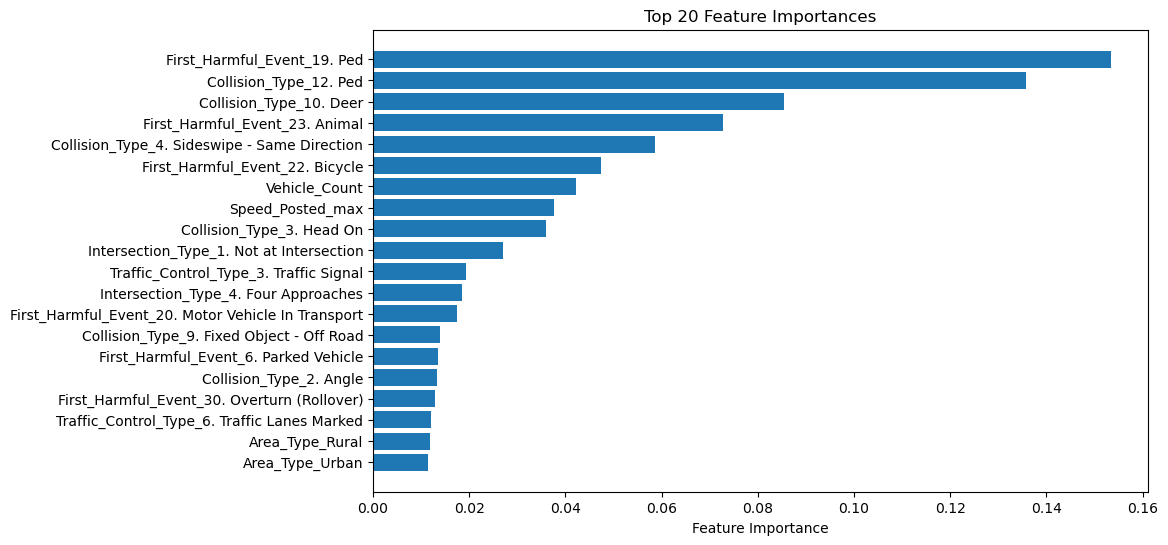

In [16]:
# Feature importance
def get_feature_names(preprocessor):
    num_features = preprocessor.named_transformers_['num'].named_steps['impute'].get_feature_names_out(numeric_feats)
    cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_feats)
    return np.concatenate([num_features, cat_features])

feature_names = get_feature_names(preprocessor)
importances = rf.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp_df.head(20))

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:20][::-1], feat_imp_df['Importance'][:20][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances")
plt.show()

## Ensemble model -- RF, XGBoost, AdaBoost, LightGBM, CatBoost

In [18]:
rf   = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2,
                              n_estimators=100, random_state=42)
xgbc = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, min_child_weight=1,
                         use_label_encoder=False, eval_metric='mlogloss', random_state=42)
adb  = AdaBoostClassifier(learning_rate=0.1, n_estimators=50, random_state=42)
lgbc = lgb.LGBMClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)
catc = CatBoostClassifier(learning_rate=0.1, max_depth=3, n_estimators=100,
                          verbose=0, random_state=42)

ensemble = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgbc), ('ada', adb), ('lgb', lgbc), ('cat', catc)],
    voting='soft', n_jobs=-1
)

In [19]:
model = ImbPipeline([
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', ensemble)
])

In [20]:
model.fit(X_train, y_train)

/home/svj4hk/.local/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:38:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.811499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26223
[LightGBM] [Info] Number of data points in the train set: 2655235, number of used features: 146
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Vehicle_Count',
                                                   'Speed_Posted_max']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Intersection_...
                                                             max_leaves=None,
                                                             min_child_weight=1,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...)),
                                              ('ada',
                                               AdaBoostClassifier(learning_rate=0.1,
                                                                  random_state=42)),
                                              ('lgb',
                                               LGBMClassifier(max_depth=3,
                                                              random_state=42)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x7f622f53c150>)],
                                  n_jobs=-1, voting='soft'))])

In [21]:
y_pred = model.predict(X_test)

/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [22]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.3823
Classification Report:
              precision    recall  f1-score   support

           A       0.11      0.24      0.15     16404
           B       0.28      0.16      0.21     66161
           C       0.12      0.53      0.20     26285
           K       0.04      0.46      0.08      2267
           O       0.77      0.44      0.56    227542

    accuracy                           0.38    338659
   macro avg       0.27      0.36      0.24    338659
weighted avg       0.59      0.38      0.44    338659



In [23]:
y_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print(f"ROC-AUC (macro): {auc:.4f}")

/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ROC-AUC (macro): 0.6895


<Figure size 1000x600 with 0 Axes>

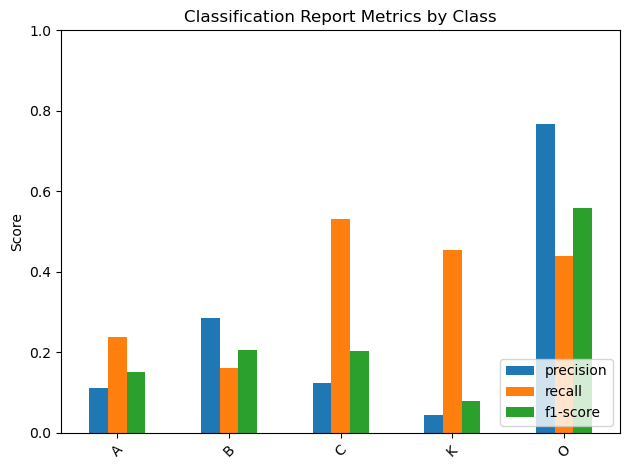

In [24]:
# plot report
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

class_metrics = report_df.iloc[:-3][['precision', 'recall', 'f1-score']]

plt.figure(figsize=(10, 6))
class_metrics.plot(kind='bar')
plt.title("Classification Report Metrics by Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

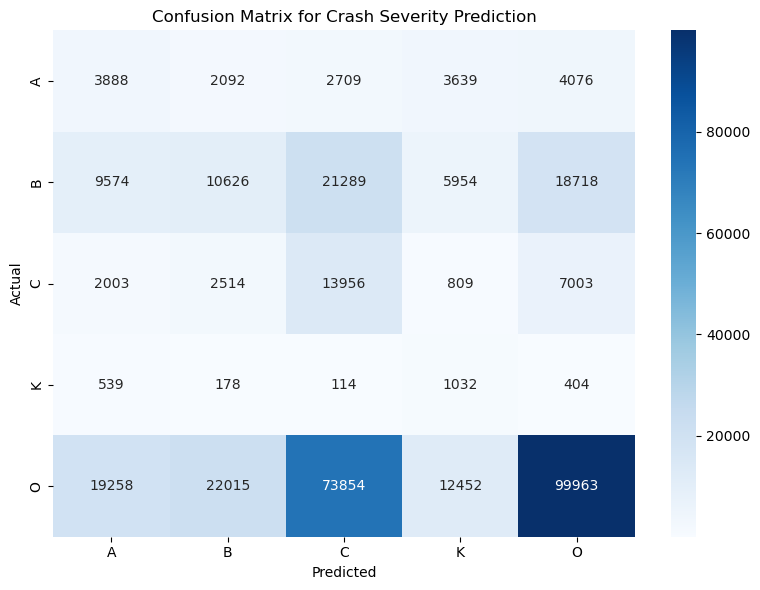

In [25]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Crash Severity Prediction')
plt.tight_layout()
plt.show()

# Models -- Distracted factors included

Now, models with the follwing attr included 'Alcohol?', 'Unrestrained?', 'Distracted?', 'Drowsy?', 'Drug_Related?', 'Speed?', predict crash severity

### Pipeline -- Distracted factors included

In [2]:
df = pd.read_csv("crash_data_yfactors.csv")

In [3]:
df.shape

(1128862, 22)

In [4]:
df.head()

,Intersection_Type,Area_Type,Roadway_Alignment,Light_Condition,Weather_Condition,Roadway_Surface_Condition,Roadway_Surface_Type,Traffic_Control_Type,Traffic_Control_Status,Collision_Type,...,Crash_Severity,Alcohol?,Unrestrained?,Distracted?,Drowsy?,Drug_Related?,Speed?,day_of_week,time_of_day,Speed_Posted_max
0,1. Not at Intersection,Urban,1. Straight - Level,4. Darkness - Road Lighted,1. No Adverse Condition (Clear/Cloudy),1. Dry,"2. Blacktop, Asphalt, Bituminous",17. Highway Safety Corridor,1. Yes - Working,1. Rear End,...,O,No,Belted,No,No,No,Yes,Tuesday,Morning,60.0
1,1. Not at Intersection,Urban,1. Straight - Level,2. Daylight,1. No Adverse Condition (Clear/Cloudy),1. Dry,1. Concrete,6. Traffic Lanes Marked,1. Yes - Working,2. Angle,...,O,No,Belted,No,No,No,No,Tuesday,Afternoon,35.0
2,1. Not at Intersection,Rural,1. Straight - Level,4. Darkness - Road Lighted,1. No Adverse Condition (Clear/Cloudy),1. Dry,"2. Blacktop, Asphalt, Bituminous",6. Traffic Lanes Marked,1. Yes - Working,9. Fixed Object - Off Road,...,B,Yes,Belted,No,No,No,No,Saturday,Evening,55.0
3,1. Not at Intersection,Urban,1. Straight - Level,5. Darkness - Road Not Lighted,5. Rain,2. Wet,"2. Blacktop, Asphalt, Bituminous",6. Traffic Lanes Marked,6. No Traffic Control Device Present,1. Rear End,...,O,No,Belted,No,No,No,No,Saturday,Night,35.0
4,3. Three Approaches,Rural,3. Grade - Straight,2. Daylight,1. No Adverse Condition (Clear/Cloudy),1. Dry,"2. Blacktop, Asphalt, Bituminous",4. Stop Sign,1. Yes - Working,1. Rear End,...,O,No,Belted,No,No,No,No,Monday,Morning,55.0


In [5]:
X = df.drop(columns=['Crash_Severity'])
y = df['Crash_Severity']

In [6]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

print(y_enc)

[4 4 1 ... 1 1 4]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.30,
    # stratify=y_enc,
    random_state=42
)

In [8]:
numeric_feats = ['Vehicle_Count','Speed_Posted_max']
numeric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_feats = [
    'Intersection_Type','Area_Type','Roadway_Alignment',
    'Light_Condition','Weather_Condition',
    'Roadway_Surface_Condition','Roadway_Surface_Type',
    'Traffic_Control_Type','Traffic_Control_Status',
    'Collision_Type','First_Harmful_Event',
    'day_of_week','time_of_day',
    
    'Alcohol?', 'Unrestrained?', 'Distracted?', 'Drowsy?', 'Drug_Related?', 'Speed?'
]
categorical_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_feats),
    ('cat', categorical_pipe, categorical_feats)
])


## Random Forest

In [9]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [11]:
rf   = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_train_prep, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [12]:
y_pred = rf.predict(X_test_prep)

In [13]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.6805
Classification Report:
              precision    recall  f1-score   support

           A       0.38      0.02      0.03     16404
           B       0.51      0.05      0.09     66161
           C       0.00      0.00      0.00     26285
           K       0.62      0.01      0.01      2267
           O       0.68      1.00      0.81    227542

    accuracy                           0.68    338659
   macro avg       0.44      0.21      0.19    338659
weighted avg       0.58      0.68      0.56    338659



/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
y_proba = rf.predict_proba(X_test_prep)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print(f"ROC-AUC (macro): {auc:.4f}")

ROC-AUC (macro): 0.7294


/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x600 with 0 Axes>

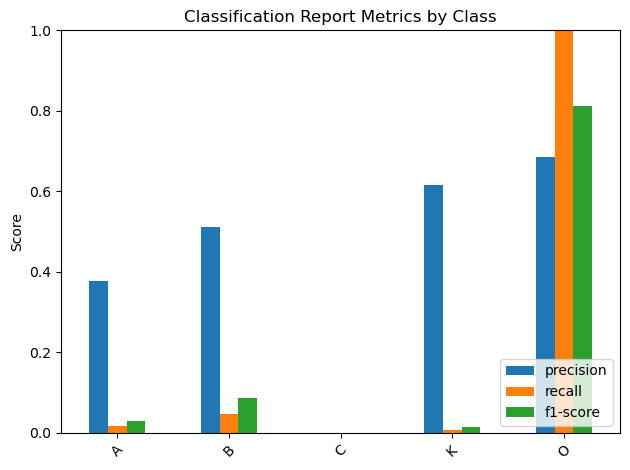

In [16]:
# plot report
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

class_metrics = report_df.iloc[:-3][['precision', 'recall', 'f1-score']]

plt.figure(figsize=(10, 6))
class_metrics.plot(kind='bar')
plt.title("Classification Report Metrics by Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

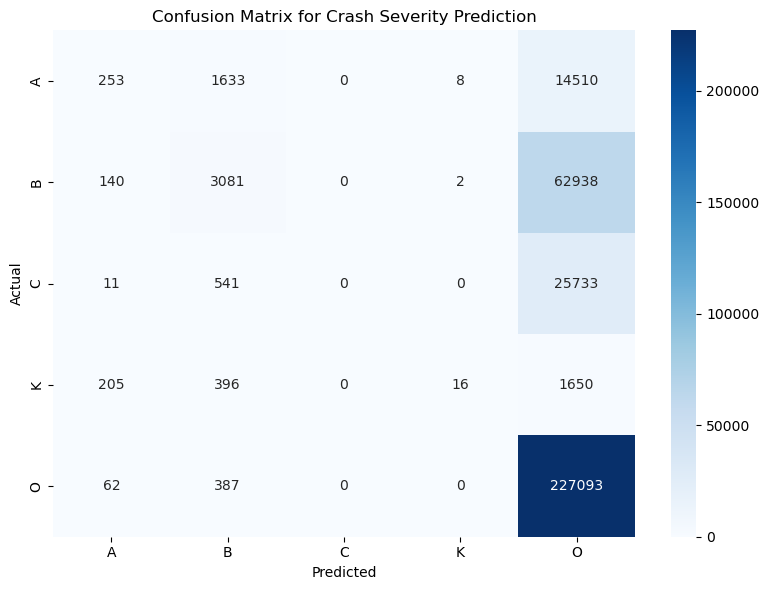

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Crash Severity Prediction')
plt.tight_layout()
plt.show()

                                               Feature  Importance
151                             Unrestrained?_Unbelted    0.144002
150                               Unrestrained?_Belted    0.111616
81                              Collision_Type_12. Ped    0.106447
105                        First_Harmful_Event_19. Ped    0.096880
110                     First_Harmful_Event_23. Animal    0.063394
79                             Collision_Type_10. Deer    0.051803
88        Collision_Type_4. Sideswipe - Same Direction    0.046004
109                    First_Harmful_Event_22. Bicycle    0.029607
1                                     Speed_Posted_max    0.025685
0                                        Vehicle_Count    0.025346
87                           Collision_Type_3. Head On    0.020980
5                 Intersection_Type_4. Four Approaches    0.018976
2             Intersection_Type_1. Not at Intersection    0.018581
149                                       Alcohol?_Yes    0.01

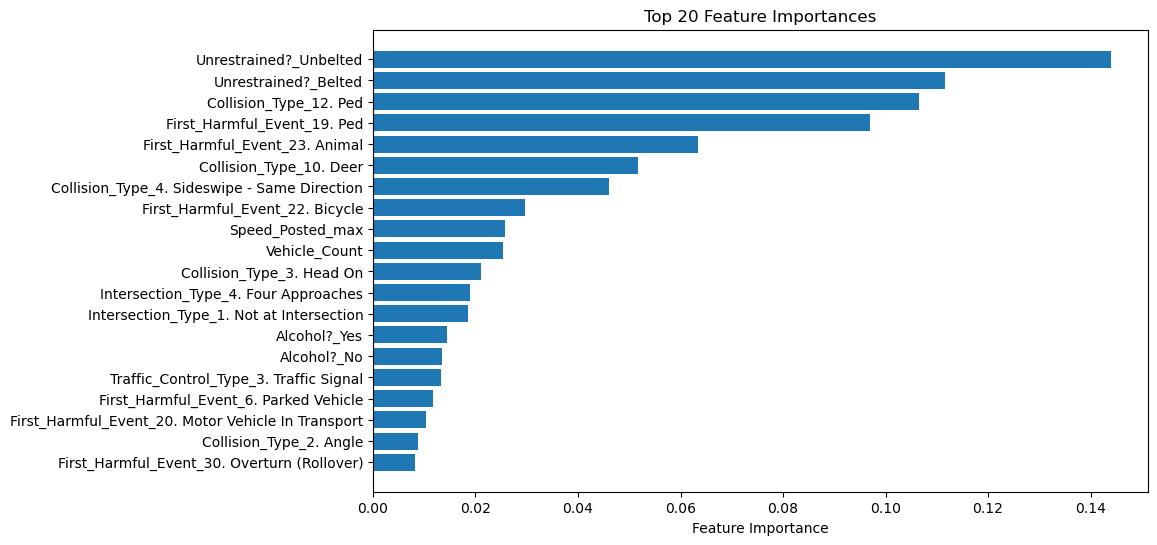

In [20]:
# Feature importance
feature_names = get_feature_names(preprocessor)
importances = rf.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp_df.head(20))

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:20][::-1], feat_imp_df['Importance'][:20][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances")
plt.show()

## Ensemble model -- RF, XGBoost, AdaBoost, LightGBM, CatBoost

In [22]:
rf   = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2,
                              n_estimators=100, random_state=42)
xgbc = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, min_child_weight=1,
                         use_label_encoder=False, eval_metric='mlogloss', random_state=42)
adb  = AdaBoostClassifier(learning_rate=0.1, n_estimators=50, random_state=42)
lgbc = lgb.LGBMClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)
catc = CatBoostClassifier(learning_rate=0.1, max_depth=3, n_estimators=100,
                          verbose=0, random_state=42)

ensemble = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgbc), ('ada', adb), ('lgb', lgbc), ('cat', catc)],
    voting='soft', n_jobs=-1
)

In [23]:
model = ImbPipeline([
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', ensemble)
])

In [24]:
model.fit(X_train, y_train)

/home/svj4hk/.local/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:55:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.126704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29778
[LightGBM] [Info] Number of data points in the train set: 2655235, number of used features: 158
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Vehicle_Count',
                                                   'Speed_Posted_max']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Intersection_...
                                                             max_leaves=None,
                                                             min_child_weight=1,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...)),
                                              ('ada',
                                               AdaBoostClassifier(learning_rate=0.1,
                                                                  random_state=42)),
                                              ('lgb',
                                               LGBMClassifier(max_depth=3,
                                                              random_state=42)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x7fb98e150590>)],
                                  n_jobs=-1, voting='soft'))])

In [25]:
y_pred = model.predict(X_test)

/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [26]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.4607
Classification Report:
              precision    recall  f1-score   support

           A       0.15      0.22      0.18     16404
           B       0.33      0.11      0.16     66161
           C       0.12      0.50      0.20     26285
           K       0.10      0.53      0.17      2267
           O       0.75      0.58      0.65    227542

    accuracy                           0.46    338659
   macro avg       0.29      0.39      0.27    338659
weighted avg       0.58      0.46      0.49    338659



In [27]:
y_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print(f"ROC-AUC (macro): {auc:.4f}")

/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ROC-AUC (macro): 0.7110


<Figure size 1000x600 with 0 Axes>

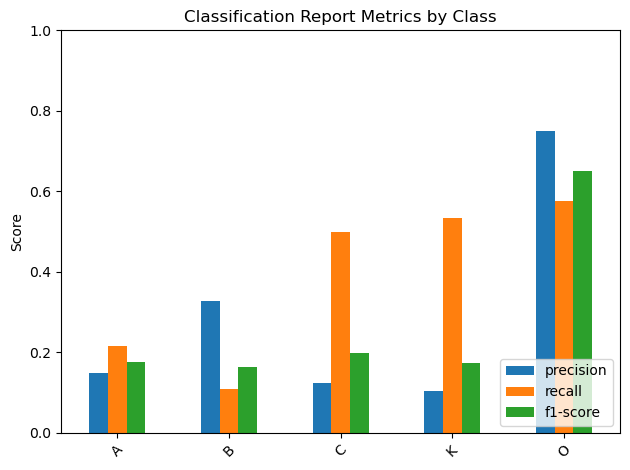

In [28]:
# plot report
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

class_metrics = report_df.iloc[:-3][['precision', 'recall', 'f1-score']]

plt.figure(figsize=(10, 6))
class_metrics.plot(kind='bar')
plt.title("Classification Report Metrics by Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

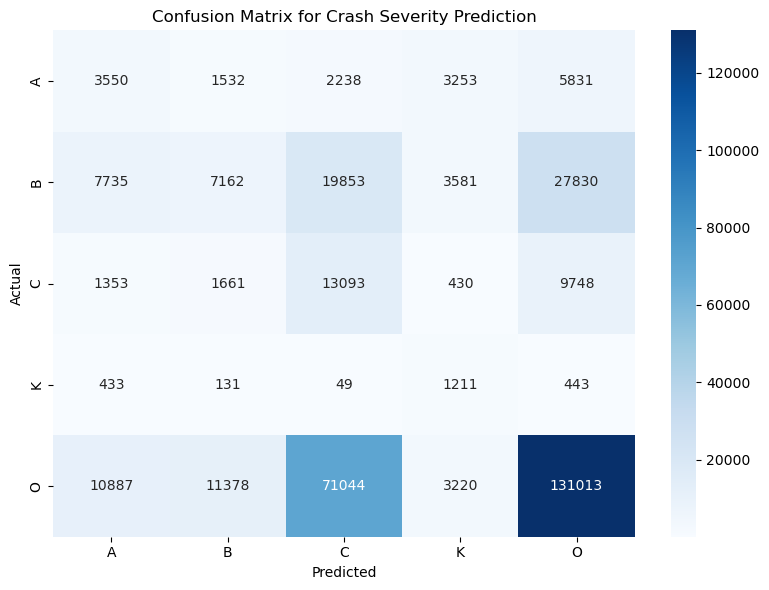

In [29]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Crash Severity Prediction')
plt.tight_layout()
plt.show()